In [2]:
# Import packages
import plotly.graph_objects as go
import pandas as pd
import os
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import numpy as np

In [3]:
data = pd.read_csv('https://huggingface.co/spaces/Anniek/Time_series_forecast/raw/945f1ca228e4102c4c803f250e90d974644cf0bc/AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])
data['month_num'] = data['Month'].dt.month

## Преобразование Бокса-Кокса

In [4]:
# Стабилизируем дисперсию с помощью преобразования Бокса-Кокса и приводим ряд к стационарному (среднее значение не изменяется во времени)
data['Passengers_Boxcox'], lam = boxcox(data['#Passengers'])
data.dropna(inplace=True)

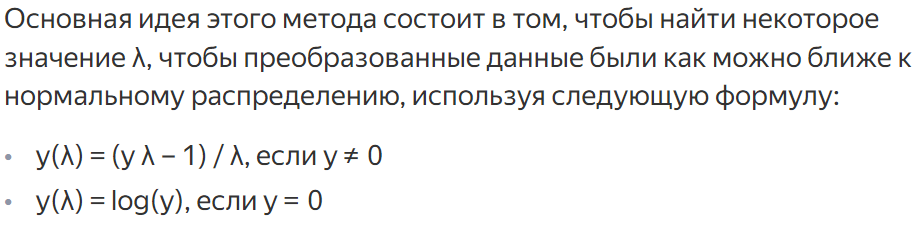

Подробнее тут: https://www.codecamp.ru/blog/box-cox-transformation-python/


In [6]:
data.head()

,Month,#Passengers,month_num,Passengers_Boxcox
0,1949-01-01,112,1,6.827489
1,1949-02-01,118,2,6.932821
2,1949-03-01,132,3,7.161890
3,1949-04-01,129,4,7.114609
4,1949-05-01,121,5,6.983785


In [4]:
# Получаем признаки Фурье на основе N числа гармоник
for order in range(1, 5):
    data[f'fourier_sin_order_{order}'] = np.sin(2 * np.pi * order * data['month_num'] / 12)
    data[f'fourier_cos_order_{order}'] = np.cos(2 * np.pi * order * data['month_num'] / 12)

In [5]:
# name of fourier features
fourier_features = [i for i in list(data) if i.startswith('fourier')]

In [6]:
fourier_features

['fourier_sin_order_1',
 'fourier_cos_order_1',
 'fourier_sin_order_2',
 'fourier_cos_order_2',
 'fourier_sin_order_3',
 'fourier_cos_order_3',
 'fourier_sin_order_4',
 'fourier_cos_order_4']

In [7]:
# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

## Pmdarima 

является оболочкой модели ARIMA и поставляется с функцией, которая автоматически находит лучшие гиперпараметры (p, d, q) для модели ARIMA.

In [8]:
# !pip install pmdarima

In [9]:
train[fourier_features].head()

,fourier_sin_order_1,fourier_cos_order_1,fourier_sin_order_2,fourier_cos_order_2,fourier_sin_order_3,fourier_cos_order_3,fourier_sin_order_4,fourier_cos_order_4
0,0.500000,8.660254e-01,8.660254e-01,0.5,1.000000e+00,6.123234e-17,8.660254e-01,-0.5
1,0.866025,5.000000e-01,8.660254e-01,-0.5,1.224647e-16,-1.000000e+00,-8.660254e-01,-0.5
2,1.000000,6.123234e-17,1.224647e-16,-1.0,-1.000000e+00,-1.836970e-16,-2.449294e-16,1.0
3,0.866025,-5.000000e-01,-8.660254e-01,-0.5,-2.449294e-16,1.000000e+00,8.660254e-01,-0.5
4,0.500000,-8.660254e-01,-8.660254e-01,0.5,1.000000e+00,1.194340e-15,-8.660254e-01,-0.5


In [8]:
# Строим модель auto-ARIMA по признакам Фурье

import pmdarima as pm
model = pm.auto_arima(train['Passengers_Boxcox'],
                        X=train[fourier_features],
                        seasonal=False,
                        stepwise=True,
                        suppress_warnings=True,
                        max_order=None,
                        information_criterion='aicc',
                        error_action="ignore")

## Информационный критерий Акаике:

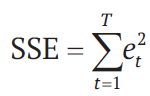

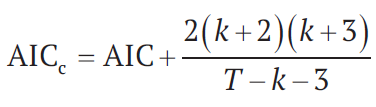

где T – это число наблюдений, использованных для оценивания, и k – число предсказателей в модели. Лучшей признается та модель, для которой значения информационного критерия AIC минимальны.


In [11]:
# Получаем прогнозы и применяем обратное преобразование Бокса-Кокса
boxcox_forecasts = model.predict(n_periods=len(test), X=test[fourier_features])
forecasts = inv_boxcox(boxcox_forecasts, lam)

In [12]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
fig.update_layout(template="simple_white", font=dict(size=18), title_text='',
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')
